# Time Series Forecasting

## Univariate, multivariate, LSTM vs XGBoost

In [1]:
! pip install xgboost

## Read the dataset

In [2]:
!gdown 1UPyrvIqB-UCyqGR8wq3IJJsc7ClxQMeZ

Downloading...
From: https://drive.google.com/uc?id=1UPyrvIqB-UCyqGR8wq3IJJsc7ClxQMeZ
To: /content/amazon_stock_price.csv
100% 414k/414k [00:00<00:00, 103MB/s]


In [3]:
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [4]:
data = pd.read_csv('amazon_stock_price.csv')

In [5]:
data.head()

,date,open,high,low,close,volume
0,1997-05-15,0.1219,0.1250,0.0964,0.0979,1443120000
1,1997-05-16,0.0984,0.0990,0.0854,0.0865,294000000
2,1997-05-19,0.0880,0.0885,0.0812,0.0854,122136000
3,1997-05-20,0.0865,0.0875,0.0818,0.0818,109344000
4,1997-05-21,0.0818,0.0823,0.0688,0.0714,377064000


In [6]:
data.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

The task is to predict the 'close' price of the stock for 1 day ahead using the values of the 5 previous days

## Univariate forecasting

Univariate means using only past values of the variable 'close' to predict future values of it.

Pandas has the utility function `shift(n)` which can be called on a dataframe or series and returns the value of that dataframe (series) from the previous n rows.

Let's create the values for the variable `close` from the previous 5 days.

In [7]:
data = data.set_index('date')

In [8]:
data = data.sort_index()

In [9]:
lag = 5

In [10]:
for i in range(1, lag + 1):
  data[f'close_prev_{i}'] = data['close'].shift(i)

Let's see the dataframe.

**Note: Now we have missing values in the first rows. This is because no data is available before the first row in the dataset. By doing this we use as many rows as we want to take previous values.**

In [11]:
data.head(10)

,open,high,low,close,volume,close_prev_1,close_prev_2,close_prev_3,close_prev_4,close_prev_5
date,,,,,,,,,,
1997-05-15,0.1219,0.1250,0.0964,0.0979,1443120000,NaN,NaN,NaN,NaN,NaN
1997-05-16,0.0984,0.0990,0.0854,0.0865,294000000,0.0979,NaN,NaN,NaN,NaN
1997-05-19,0.0880,0.0885,0.0812,0.0854,122136000,0.0865,0.0979,NaN,NaN,NaN
1997-05-20,0.0865,0.0875,0.0818,0.0818,109344000,0.0854,0.0865,0.0979,NaN,NaN
1997-05-21,0.0818,0.0823,0.0688,0.0714,377064000,0.0818,0.0854,0.0865,0.0979,NaN
1997-05-22,0.0719,0.0724,0.0656,0.0698,235536000,0.0714,0.0818,0.0854,0.0865,0.0979
1997-05-23,0.0703,0.0760,0.0667,0.0750,318744000,0.0698,0.0714,0.0818,0.0854,0.0865
1997-05-27,0.0755,0.0823,0.0729,0.0792,173952000,0.0750,0.0698,0.0714,0.0818,0.0854
1997-05-28,0.0812,0.0818,0.0766,0.0766,91488000,0.0792,0.0750,0.0698,0.0714,0.0818


In [12]:
data.isnull().sum()

open            0
high            0
low             0
close           0
volume          0
close_prev_1    1
close_prev_2    2
close_prev_3    3
close_prev_4    4
close_prev_5    5
dtype: int64

In [13]:
data = data.dropna(axis=0)

In [14]:
features = [f'close_prev_{i}' for i in range(1, lag + 1)]

In [15]:
X, Y = data[features], data['close']

In [16]:
X

,close_prev_1,close_prev_2,close_prev_3,close_prev_4,close_prev_5
date,,,,,
1997-05-22,0.0714,0.0818,0.0854,0.0865,0.0979
1997-05-23,0.0698,0.0714,0.0818,0.0854,0.0865
1997-05-27,0.0750,0.0698,0.0714,0.0818,0.0854
1997-05-28,0.0792,0.0750,0.0698,0.0714,0.0818
1997-05-29,0.0766,0.0792,0.0750,0.0698,0.0714
...,...,...,...,...,...
2023-11-30,146.3200,147.0300,147.7300,146.7400,146.7100
2023-12-01,146.0900,146.3200,147.0300,147.7300,146.7400
2023-12-04,147.0300,146.0900,146.3200,147.0300,147.7300


When performing the dataset splitting, we must not shuffle the rows. This is because in forecasting our data is dependent on the date(time). This means we can't use future events for training a model (for example, we can train on all data from 2018 to 2021, and test on all data from 2022 to 2023).

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [18]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
Y_train = scaler.fit_transform(Y_train.values.reshape(-1, 1))

In [19]:
X_train.shape

(5344, 5)

The shape should be [samples, timesteps, features]

In [20]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [21]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [22]:
X_train.shape

(5344, 5, 1)

In [23]:
model = Sequential()
model.add(LSTM(100,  activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(50,  activation='relu'))
model.add(Dense(1, activation='linear'))

In [24]:
model.compile(loss=keras.losses.MeanSquaredError() , optimizer=keras.optimizers.Adam(), metrics=[keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError() ])

In [25]:
history = model.fit(X_train, Y_train, batch_size=16, validation_split=0.2, epochs=20, shuffle=False)

Epoch 1/20
268/268 [==============================] - 17s 26ms/step - loss: 1.3586e-04 - mean_squared_error: 1.3586e-04 - mean_absolute_error: 0.0084 - val_loss: 0.0690 - val_mean_squared_error: 0.0690 - val_mean_absolute_error: 0.1935
Epoch 2/20
268/268 [==============================] - 8s 31ms/step - loss: 9.2721e-04 - mean_squared_error: 9.2721e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0730 - val_mean_squared_error: 0.0730 - val_mean_absolute_error: 0.1995
Epoch 3/20
268/268 [==============================] - 6s 23ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0194 - val_loss: 0.0665 - val_mean_squared_error: 0.0665 - val_mean_absolute_error: 0.1917
Epoch 4/20
268/268 [==============================] - 4s 16ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0210 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1611
Epoch 5/20
268/268 [==============================] - 5s 18ms/step - loss: 

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 100)            40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71051 (277.54 KB)
Trainable params: 71051 (277.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


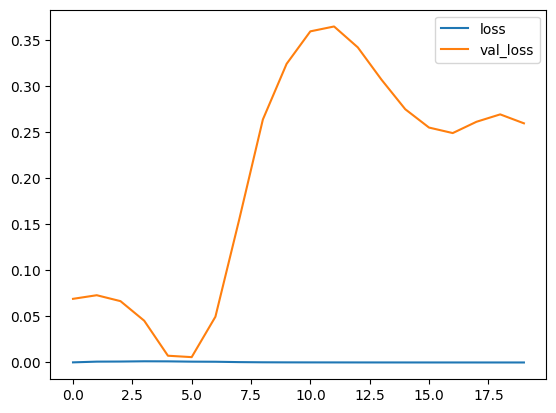

In [27]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

What does this mean?

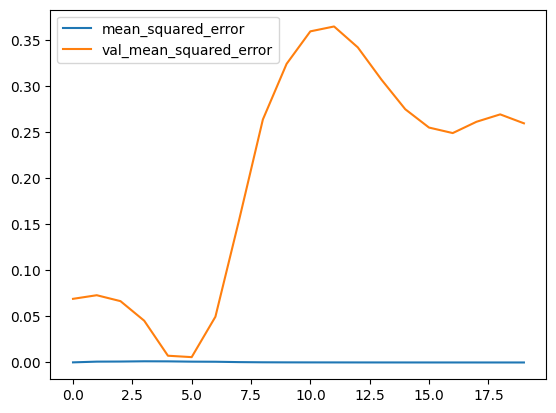

In [28]:
plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
plt.legend()
plt.show()

In [29]:
preds = model.predict(X_test)

42/42 [==============================] - 1s 4ms/step


In [30]:
preds = scaler.inverse_transform(preds)

In [31]:
mean_squared_error(preds, Y_test), mean_absolute_error(preds, Y_test), r2_score(preds, Y_test)

(600095.8196018538, 631.190420299964, -1.5995395832463548)

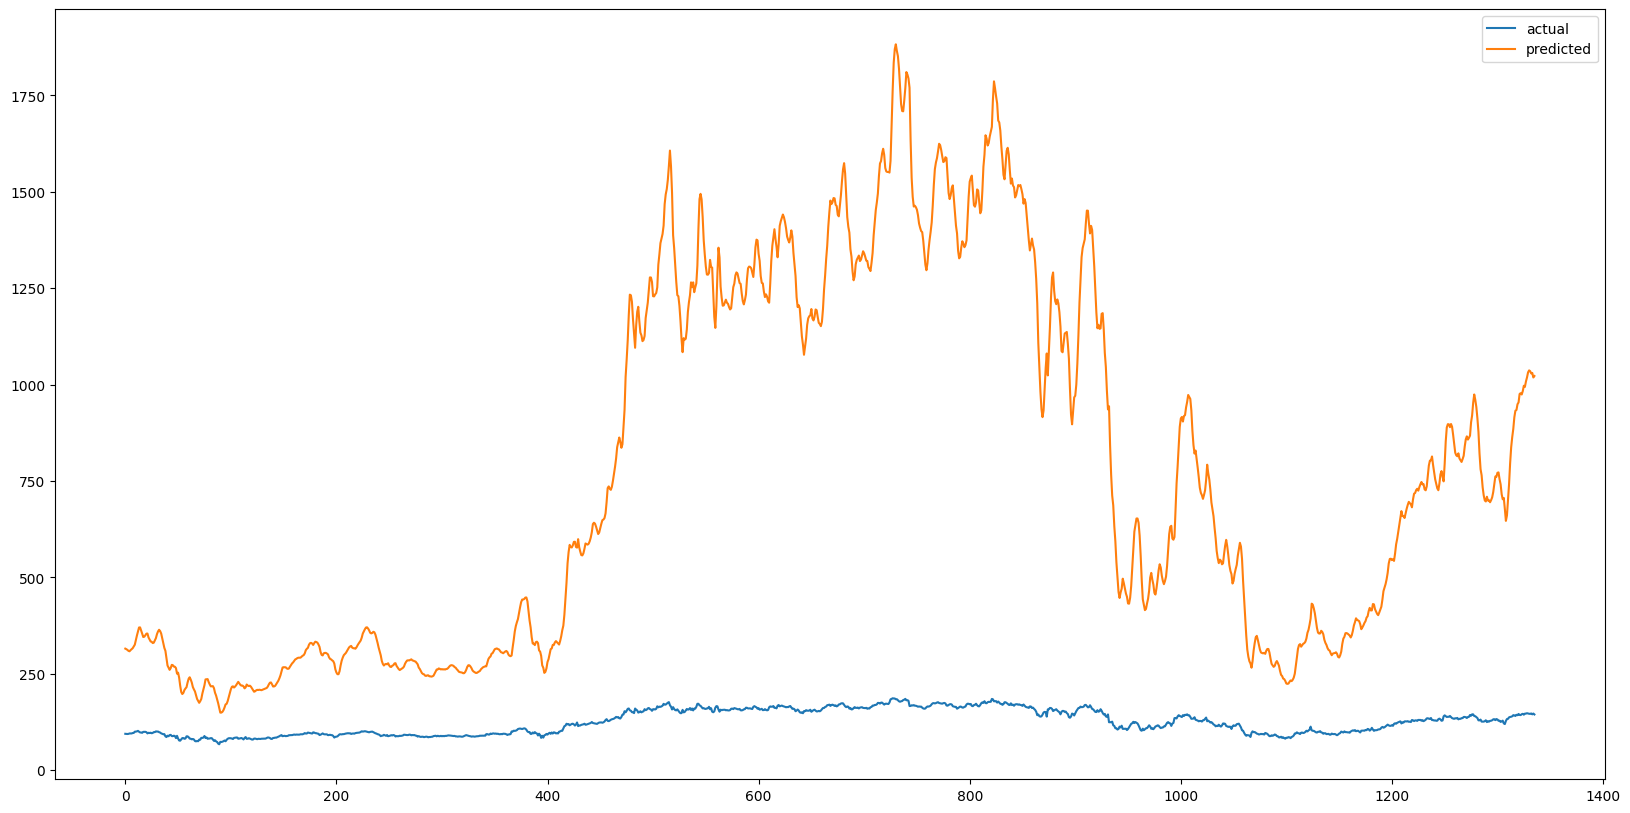

In [32]:
plt.figure(figsize=(20, 10))
plt.plot(Y_test.values, label='actual')
plt.plot(preds, label='predicted')
plt.legend()
plt.show()

## Multivariate Prediction


Now, the task is to predict the value of `close` for the next day using the last 5 days of all the other variables.

In [33]:
data = pd.read_csv('amazon_stock_price.csv')

In [34]:
data

,date,open,high,low,close,volume
0,1997-05-15,0.1219,0.1250,0.0964,0.0979,1443120000
1,1997-05-16,0.0984,0.0990,0.0854,0.0865,294000000
2,1997-05-19,0.0880,0.0885,0.0812,0.0854,122136000
3,1997-05-20,0.0865,0.0875,0.0818,0.0818,109344000
4,1997-05-21,0.0818,0.0823,0.0688,0.0714,377064000
...,...,...,...,...,...,...
6680,2023-11-30,144.7600,146.9300,144.3300,146.0900,65814000
6681,2023-12-01,146.0000,147.2500,145.5500,147.0300,39924600
6682,2023-12-04,145.2500,145.3500,142.8100,144.8400,48294200
6683,2023-12-05,143.5500,148.5700,143.1300,146.8800,46822400


In [35]:
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

In [36]:
data = data.sort_index()

In [37]:
columns = data.columns

In [38]:
for i in range(1, lag+1):
  for col in columns:
    data[f'{col}_prev_{i}'] = data[col].shift(i)

In [39]:
data.head(10)

,open,high,low,close,volume,open_prev_1,high_prev_1,low_prev_1,close_prev_1,volume_prev_1,...,open_prev_4,high_prev_4,low_prev_4,close_prev_4,volume_prev_4,open_prev_5,high_prev_5,low_prev_5,close_prev_5,volume_prev_5
date,,,,,,,,,,,,,,,,,,,,,
1997-05-15,0.1219,0.1250,0.0964,0.0979,1443120000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-16,0.0984,0.0990,0.0854,0.0865,294000000,0.1219,0.1250,0.0964,0.0979,1.443120e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-19,0.0880,0.0885,0.0812,0.0854,122136000,0.0984,0.0990,0.0854,0.0865,2.940000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-20,0.0865,0.0875,0.0818,0.0818,109344000,0.0880,0.0885,0.0812,0.0854,1.221360e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-21,0.0818,0.0823,0.0688,0.0714,377064000,0.0865,0.0875,0.0818,0.0818,1.093440e+08,...,0.1219,0.1250,0.0964,0.0979,1.443120e+09,NaN,NaN,NaN,NaN,NaN
1997-05-22,0.0719,0.0724,0.0656,0.0698,235536000,0.0818,0.0823,0.0688,0.0714,3.770640e+08,...,0.0984,0.0990,0.0854,0.0865,2.940000e+08,0.1219,0.1250,0.0964,0.0979,1.443120e+09
1997-05-23,0.0703,0.0760,0.0667,0.0750,318744000,0.0719,0.0724,0.0656,0.0698,2.355360e+08,...,0.0880,0.0885,0.0812,0.0854,1.221360e+08,0.0984,0.0990,0.0854,0.0865,2.940000e+08
1997-05-27,0.0755,0.0823,0.0729,0.0792,173952000,0.0703,0.0760,0.0667,0.0750,3.187440e+08,...,0.0865,0.0875,0.0818,0.0818,1.093440e+08,0.0880,0.0885,0.0812,0.0854,1.221360e+08
1997-05-28,0.0812,0.0818,0.0766,0.0766,91488000,0.0755,0.0823,0.0729,0.0792,1.739520e+08,...,0.0818,0.0823,0.0688,0.0714,3.770640e+08,0.0865,0.0875,0.0818,0.0818,1.093440e+08


In [40]:
data.isnull().sum()

open             0
high             0
low              0
close            0
volume           0
open_prev_1      1
high_prev_1      1
low_prev_1       1
close_prev_1     1
volume_prev_1    1
open_prev_2      2
high_prev_2      2
low_prev_2       2
close_prev_2     2
volume_prev_2    2
open_prev_3      3
high_prev_3      3
low_prev_3       3
close_prev_3     3
volume_prev_3    3
open_prev_4      4
high_prev_4      4
low_prev_4       4
close_prev_4     4
volume_prev_4    4
open_prev_5      5
high_prev_5      5
low_prev_5       5
close_prev_5     5
volume_prev_5    5
dtype: int64

In [41]:
data = data.dropna(axis=0)

In [42]:
features = data.columns.drop(['open', 'high', 'low', 'close', 'volume'])

In [43]:
features

Index(['open_prev_1', 'high_prev_1', 'low_prev_1', 'close_prev_1',
       'volume_prev_1', 'open_prev_2', 'high_prev_2', 'low_prev_2',
       'close_prev_2', 'volume_prev_2', 'open_prev_3', 'high_prev_3',
       'low_prev_3', 'close_prev_3', 'volume_prev_3', 'open_prev_4',
       'high_prev_4', 'low_prev_4', 'close_prev_4', 'volume_prev_4',
       'open_prev_5', 'high_prev_5', 'low_prev_5', 'close_prev_5',
       'volume_prev_5'],
      dtype='object')

In [44]:
X, Y = data[features], data['close']

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [46]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
Y_train = scaler.fit_transform(Y_train.values.reshape(-1, 1))

In [47]:
X_train = X_train.reshape(X_train.shape[0], lag, X_train.shape[1] // lag)
X_test = X_test.reshape(X_test.shape[0], lag, X_test.shape[1] // lag)

In [48]:
model = Sequential()
model.add(LSTM(100,  activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(50,  activation='relu'))
model.add(Dense(1, activation='linear'))

In [49]:
model.compile(loss=keras.losses.MeanSquaredError() , optimizer=keras.optimizers.Adam(), metrics=[keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError() ])

In [50]:
history = model.fit(X_train, Y_train, validation_split=0.2, batch_size=16, epochs=20,  shuffle=False)

Epoch 1/20
268/268 [==============================] - 10s 26ms/step - loss: 1.3865e-04 - mean_squared_error: 1.3865e-04 - mean_absolute_error: 0.0087 - val_loss: 0.0544 - val_mean_squared_error: 0.0544 - val_mean_absolute_error: 0.1750
Epoch 2/20
268/268 [==============================] - 3s 11ms/step - loss: 7.8400e-04 - mean_squared_error: 7.8400e-04 - mean_absolute_error: 0.0153 - val_loss: 0.0344 - val_mean_squared_error: 0.0344 - val_mean_absolute_error: 0.1441
Epoch 3/20
268/268 [==============================] - 3s 11ms/step - loss: 6.8535e-04 - mean_squared_error: 6.8535e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0719
Epoch 4/20
268/268 [==============================] - 3s 10ms/step - loss: 5.3200e-04 - mean_squared_error: 5.3200e-04 - mean_absolute_error: 0.0140 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0595
Epoch 5/20
268/268 [==============================] - 3s 12

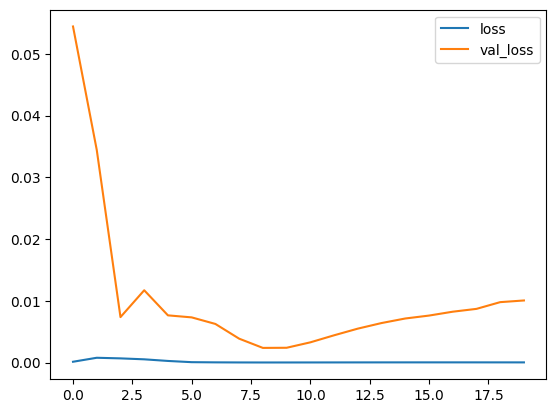

In [51]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

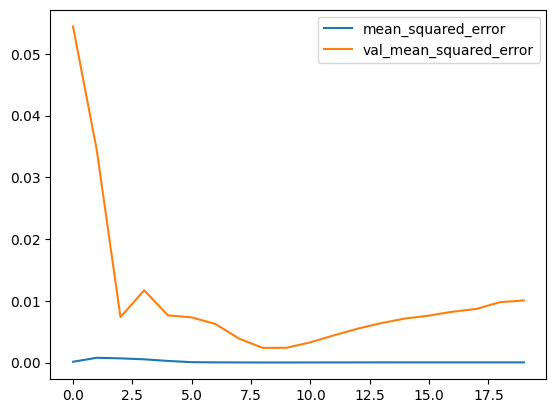

In [52]:
plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
plt.legend()
plt.show()

In [53]:
preds = model.predict(X_test)

42/42 [==============================] - 1s 6ms/step


In [54]:
preds = scaler.inverse_transform(preds)

In [55]:
mean_squared_error(preds, Y_test), mean_absolute_error(preds, Y_test), r2_score(preds, Y_test)

(265.1312351325102, 14.771278129851744, 0.8643587961053749)

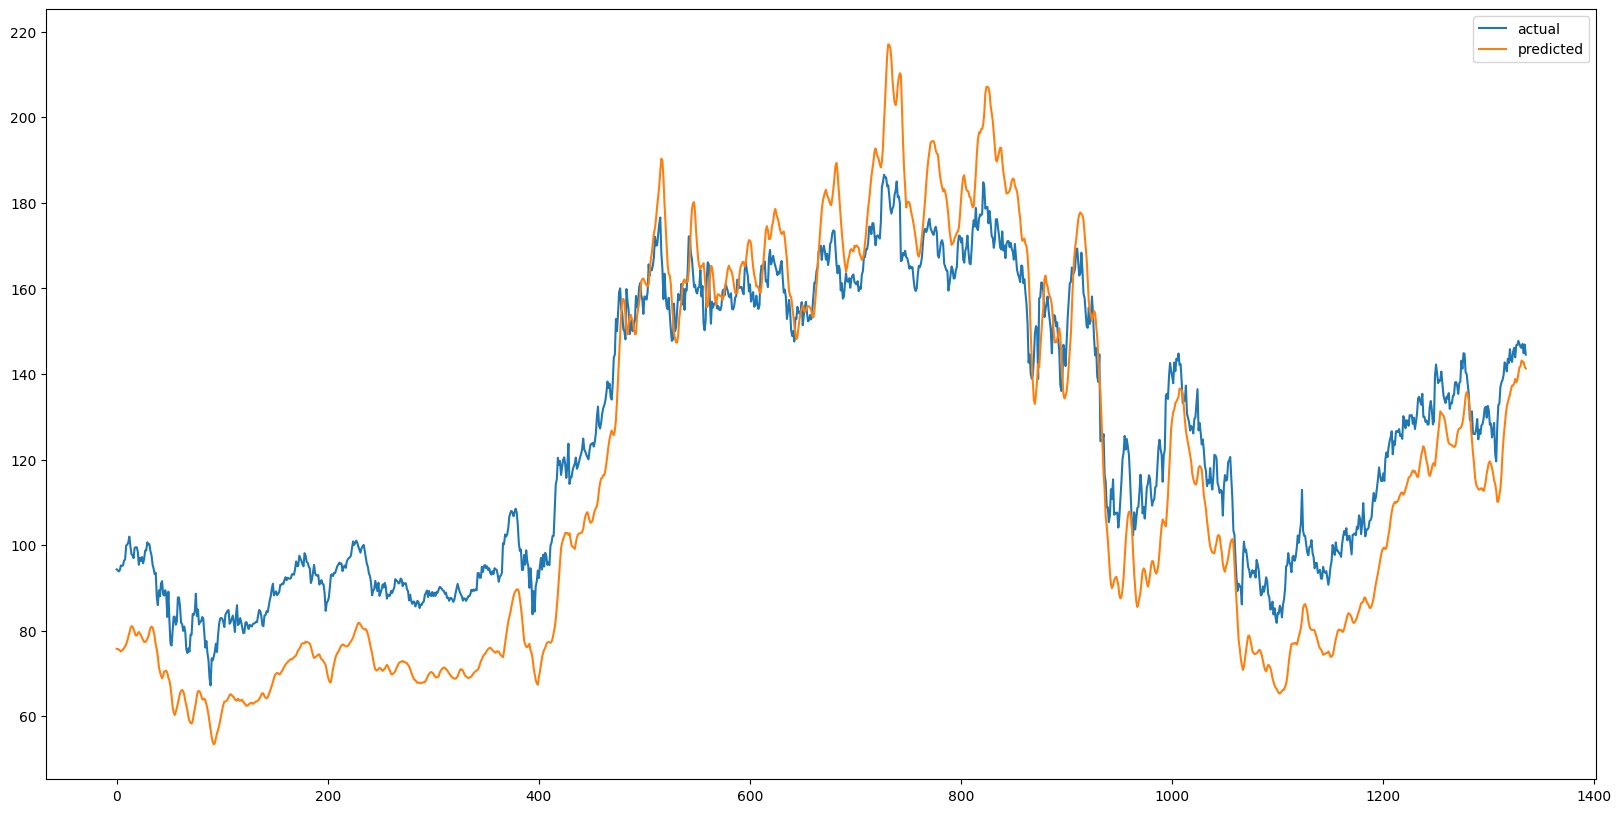

In [56]:
plt.figure(figsize=(20, 10))
plt.plot(Y_test.values, label='actual')
plt.plot(preds, label='predicted')
plt.legend()
plt.show()

## XGboost for Time Series with cross-validation

In [57]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [58]:
params = {
    "n_estimators": np.arange(50, 500, 100),
    "max_depth": [3, 5, 7]
}

In [59]:
grid_search = GridSearchCV(XGBRegressor(), cv=TimeSeriesSplit(5), param_grid=params)

In [60]:
grid_search.fit(X, Y, verbose=2)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': array([ 50, 150, 250, 350, 450])})

In [61]:
estimator = grid_search.best_estimator_

In [62]:
estimator

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=450, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [63]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [64]:
estimator.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=450, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [65]:
preds = estimator.predict(X_test)

In [66]:
mean_squared_error(preds, Y_test), mean_absolute_error(preds, Y_test), r2_score(preds, Y_test)

(1995.0487113044978, 33.48910857802523, -129.6144096257139)

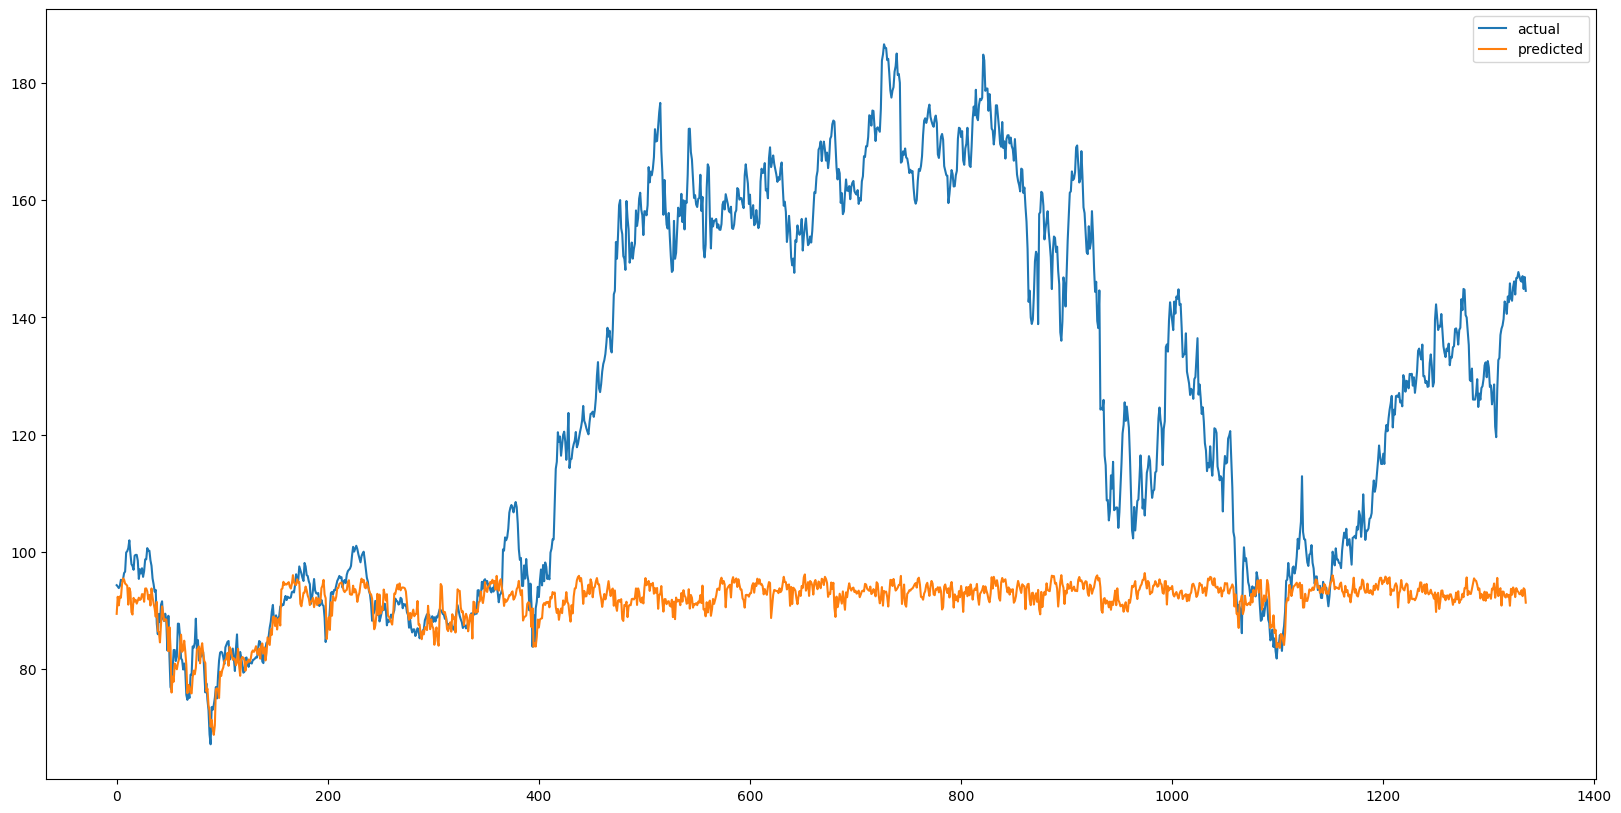

In [67]:
plt.figure(figsize=(20, 10))
plt.plot(Y_test.values, label='actual')
plt.plot(preds, label='predicted')
plt.legend()
plt.show()